In [31]:
import numpy as np
import pandas as pd 
import re
import seaborn as sns

In [8]:
# Helper functions

# This will balance the prior of preseason rank with the actual win percentage
lower_bound_week = 5
upper_bound_week = 9
def get_team_ranking(x, home_away):
    if x['schedule_week'] < lower_bound_week:
        return x[f'Predictive_{home_away}']
        return x[f'Predictive_{home_away}'] * (1-((x['schedule_week']-(lower_bound_week-1))/(upper_bound_week-lower_bound_week+1))) + x[f'rank_winpct_{home_away}'] * ((x['schedule_week']-(lower_bound_week-1))/(upper_bound_week-lower_bound_week+1))
    else:
        return x[f'rank_winpct_{home_away}']

#Similiar function for offensive and defensive rankings
lower_bound_week_offense = 3
upper_bound_week_offense = 7
def get_offensive_ranking(x, home_away):
    if x['schedule_week'] < lower_bound_week_offense:
        return x[f'Predictive_{home_away}']
    elif lower_bound_week_offense <= x['schedule_week'] <= upper_bound_week_offense:
        return x[f'Predictive_{home_away}'] * (1-((x['schedule_week']-(lower_bound_week_offense-1))/(upper_bound_week_offense-lower_bound_week_offense+1))) + x[f'rank_winpct_{home_away}'] * ((x['schedule_week']-(lower_bound_week_offense-1))/(upper_bound_week_offense-lower_bound_week_offense+1))
    else:
        return x[f'rank_winpct_{home_away}']    
    
lower_bound_week_defense = 3
upper_bound_week_defense = 7
def get_defensive_ranking(x, home_away):
    if x['schedule_week'] < lower_bound_week_defense:
        return x[f'Predictive_{home_away}']
    elif lower_bound_week_defense <= x['schedule_week'] <= upper_bound_week_defense:
        return x[f'Predictive_{home_away}'] * (1-((x['schedule_week']-(lower_bound_week_defense-1))/(upper_bound_week_defense-lower_bound_week_defense+1))) + x[f'rank_winpct_{home_away}'] * ((x['schedule_week']-(lower_bound_week_defense-1))/(upper_bound_week_defense-lower_bound_week_defense+1))
    else:
        return x[f'rank_winpct_{home_away}']    

# Process the AFC/NFC table data from Pro Football Reference and output the processed dataframe
def clean_pfr_tables(input_df, afc_or_nfc):
    
    output_df = input_df.loc[~input_df.Tm.str.contains(afc_or_nfc)]
    output_df.Tm = output_df.Tm.str.replace('[^ 0-9a-zA-Z]+', '' ,regex=True)
    return output_df
    
# Run read_html on the specified URL, then extracting both AFC/NFC and concatenating into one dataframe.
def get_weekly_data(my_url):
    week_number = re.findall("(?:week=)(\d+)", my_url)[0]
    year_number = re.findall("(?:year=)(\d+)", my_url)[0]
    tables = pd.read_html(my_url)
    afc = tables[0]
    nfc = tables[1]
    
    cleaned_afc = clean_pfr_tables(afc, "AFC")
    cleaned_nfc = clean_pfr_tables(nfc, "NFC")
    
    combined_week = pd.concat([cleaned_afc, cleaned_nfc])
    
    # The standings are as of the END of the week, so we want to add one to the week to get it to line up with our schedule
    combined_week['week_number'] = int(week_number) + 1    
    combined_week['year_number'] = year_number
    
    combined_week = combined_week.reset_index(drop=True)
    
    return combined_week

# Obtain the presesason rankings data from TeamRankings
def get_preseason_rankings(my_url, year):
    standings_data = pd.read_html(my_url)
    current_year = standings_data[0]
    current_year['season'] = year
    return current_year


### Obtain standings data for every week between 2012 and now

In [45]:
# The PFR data does have week 19 for seasons prior to 2021, which would typically comprise playoffs, but they do not update the points, record, or any of the statistics we're pulling here, so it's safe to take that data
weeks = list(range(1,19))
# Grabbing one extra year (2011) to get the end-of-season rank for offense/defense to use at beginning of 2012 season
years = list(range(2011,2022))
df_list = []

for year in years:
    for week in weeks:
        df_list.append(get_weekly_data(f'https://www.pro-football-reference.com/boxscores/standings.cgi?week={week}&year={year}&wk_league=NFL'))
        
full_standings_data = pd.concat(df_list, axis=0, ignore_index = True)
full_standings_data.to_csv("./full_standings_data.csv")

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [64]:
# Read already generated standings data

full_standings_data = pd.read_csv("./full_standings_data.csv").drop("Unnamed: 0", axis = 1)

full_standings_data[['Pts', 'PtsO', 'W', 'L', 'T', 'year_number', 'week_number']] = full_standings_data[['Pts', 'PtsO', 'W', 'L', 'T', 'year_number', 'week_number']].apply(pd.to_numeric, errors = 'coerce', axis=1)

# in 2011, there were no ties, so PFR data shows the tie column as null, this fills those NAs
full_standings_data[['T']] = full_standings_data[['T']].fillna(0)

full_standings_data['off_ppg'] = full_standings_data.Pts / (full_standings_data['W'] + full_standings_data['L'] + 
                                                                              full_standings_data['T'])

full_standings_data['def_ppg'] = full_standings_data.PtsO / (full_standings_data['W'] + full_standings_data['L'] + 
                                                                              full_standings_data['T'])

full_standings_data['rank_offense'] = full_standings_data.groupby(['year_number', 'week_number'])['off_ppg'].rank(method = 'first', ascending = False)
full_standings_data['rank_defense'] = full_standings_data.groupby(['year_number', 'week_number'])['def_ppg'].rank(method = 'first', ascending = True)

full_standings_data['rank_winpct'] = full_standings_data.groupby(['year_number', 'week_number'])['W-L%'].rank(method = 'first', ascending = False)

#full_standings_data.shape
#full_standings_data.head(10)
full_standings_data[full_standings_data['year_number'] >= 2012].shape

(5758, 16)

In [68]:
prior_season_ending_rankings = full_standings_data[full_standings_data.week_number == 19]

prior_season_ending_rankings.drop(['W', 'L', 'W-L%', 'Pts', 'PtsO', 'PtDif', 'MoV', 'week_number', 'T', 'off_ppg', 'def_ppg', 'rank_winpct'], axis=1, inplace=True)

#prior_season_ending_rankings.columns = ['Tm', 'year_number', 'off_rank_last_year', 'def_rank_last_year']

# Merge does not allow for non-equijoins, so we join every team against itself
current_and_prior = pd.merge(full_standings_data, prior_season_ending_rankings.add_suffix("_prior"), 
                                how = "left", left_on = ['Tm'], 
                                right_on=['Tm_prior'])

# Then cut down to only where the prior year is one behind the current here
# TODO -- this does not work with teams who have a name/location switch, need to get the team name mapping correct
current_and_prior = current_and_prior[(current_and_prior['year_number_prior']==current_and_prior['year_number'] - 1)]

current_and_prior.to_csv("current_and_prior_year_standings.csv")

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Below is the code used to obtain preseason ratings data for every year between 2012 and now

In [9]:

preseason_rankings_list = []
years = list(range(2012,2022))

# Getting the rankings as of August 30th of each year, which is effectively the preseason ranking as Week 1 has never started this early but it's close to the beginning of the year
for year in years:
    preseason_rankings_list.append(get_preseason_rankings(my_url = f"https://www.teamrankings.com/nfl/rankings/teams/?date={year}-08-30", year = year))
    
preseason_rankings_df = pd.concat(preseason_rankings_list, axis=0, ignore_index = True)
preseason_rankings_df.to_csv("./preseason_rankings_df.csv")

In [298]:
# Read already generated preseason_ratings data

#preseason_rankings_df = pd.read_csv("./preseason_rankings_df.csv")

In [10]:
teams = pd.read_csv('../input/nfl-scores-and-betting-data/nfl_teams.csv')
teams.head()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central


In [38]:
scores = pd.read_csv('../input/nfl-scores-and-betting-data/spreadspoke_scores.csv')
scores['schedule_week'] = pd.to_numeric(scores.schedule_week, errors = "coerce")
scores = scores.dropna(subset = ['schedule_week'])

# filter scores data
recent_scores = scores[scores["schedule_season"].isin(list(range(2012, 2022)))]

recent_scores.loc[:,'margin_of_victory'] = abs(recent_scores.loc[:,'score_home'] - recent_scores.loc[:,'score_away'])

recent_scores.loc[:, 'blowout'] = recent_scores.loc[:, 'margin_of_victory'] > 14

# Remove unnecessary columns
recent_scores.drop(['schedule_playoff'], axis = 1, inplace=True)

recent_scores.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,schedule_date,schedule_season,schedule_week,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,margin_of_victory,blowout
10542,9/5/2012,2012,1.0,New York Giants,17.0,24.0,Dallas Cowboys,NYG,-4.0,46,MetLife Stadium,False,77.0,5.0,63.0,NaN,7.0,False
10543,9/9/2012,2012,1.0,Arizona Cardinals,20.0,16.0,Seattle Seahawks,SEA,-3.0,41,University of Phoenix Stadium,False,72.0,0.0,NaN,DOME,4.0,False
10544,9/9/2012,2012,1.0,Chicago Bears,41.0,21.0,Indianapolis Colts,CHI,-10.0,42.5,Soldier Field,False,70.0,11.0,66.0,NaN,20.0,True
10545,9/9/2012,2012,1.0,Cleveland Browns,16.0,17.0,Philadelphia Eagles,PHI,-9.5,42,FirstEnergy Stadium,False,68.0,9.0,57.0,NaN,1.0,False
10546,9/9/2012,2012,1.0,Denver Broncos,31.0,19.0,Pittsburgh Steelers,DEN,-2.0,45.5,Sports Authority Field at Mile High,False,85.0,9.0,12.0,NaN,12.0,False


In [39]:
# Join Scores data to Standings data, first on the home team to get standings of the home team as of kickoff
scores_and_standings = pd.merge(recent_scores, full_standings_data[['Tm', 'W', 'L', 'T', 'Pts', 'PtsO', 'week_number', 'year_number', 'off_ppg', 'def_ppg', 'rank_offense',
       'rank_defense', 'rank_winpct']].add_suffix("_home"), 
                                how = "left", left_on = ['schedule_season', 'schedule_week', 'team_home'], 
                                right_on=['year_number_home', 'week_number_home', 'Tm_home'])

# Next join on the away team
scores_and_standings_all = pd.merge(scores_and_standings, full_standings_data[['Tm', 'W', 'L', 'T', 'Pts', 'PtsO', 'week_number', 'year_number', 'off_ppg', 'def_ppg', 'rank_offense',
       'rank_defense', 'rank_winpct']].add_suffix("_away"), 
                                how = "left", left_on = ['schedule_season', 'schedule_week', 'team_away'], 
                                right_on=['year_number_away', 'week_number_away', 'Tm_away'])

# For all week 1 games, the standings data with be NAN, because there are no standings at that point. Need to replace these with 0 to allow for EDA and other processing
scores_and_standings_all[['W_home', 'L_home', 'T_home', 'Pts_home', 'PtsO_home', 'week_number_home', 'year_number_home', 'off_ppg_home', 
                          'def_ppg_home', 'rank_offense_home','rank_defense_home', 'rank_winpct_home', 'W_away', 'L_away', 'T_away', 
                          'Pts_away', 'PtsO_away', 'week_number_away', 'year_number_away', 'off_ppg_away', 'def_ppg_away', 'rank_offense_away',
                          'rank_defense_away', 'rank_winpct_away']] = scores_and_standings_all[['W_home', 'L_home', 'T_home', 'Pts_home', 'PtsO_home', 'week_number_home', 'year_number_home', 'off_ppg_home', 
                          'def_ppg_home', 'rank_offense_home','rank_defense_home', 'rank_winpct_home', 'W_away', 'L_away', 'T_away', 
                          'Pts_away', 'PtsO_away', 'week_number_away', 'year_number_away', 'off_ppg_away', 'def_ppg_away', 'rank_offense_away',
                          'rank_defense_away', 'rank_winpct_away']].fillna(0)

# Get rid of unnecessary columns
scores_and_standings_all.drop(['Tm_home', 'Tm_away', 'year_number_home', 'week_number_home', 'year_number_away', 'week_number_away'], axis=1, inplace=True)

scores_and_standings_all.head()

,schedule_date,schedule_season,schedule_week,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,...,W_away,L_away,T_away,Pts_away,PtsO_away,off_ppg_away,def_ppg_away,rank_offense_away,rank_defense_away,rank_winpct_away
0,9/5/2012,2012,1.0,New York Giants,17.0,24.0,Dallas Cowboys,NYG,-4.0,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9/9/2012,2012,1.0,Arizona Cardinals,20.0,16.0,Seattle Seahawks,SEA,-3.0,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9/9/2012,2012,1.0,Chicago Bears,41.0,21.0,Indianapolis Colts,CHI,-10.0,42.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9/9/2012,2012,1.0,Cleveland Browns,16.0,17.0,Philadelphia Eagles,PHI,-9.5,42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9/9/2012,2012,1.0,Denver Broncos,31.0,19.0,Pittsburgh Steelers,DEN,-2.0,45.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Next, join in the rankings data for the home team, giving us a preseason rank 
scores_and_rankings = pd.merge(scores_and_standings_all, preseason_rankings_df.add_suffix("_home"), 
                                how = "left", left_on = ['schedule_season', 'team_home'], 
                                right_on=['season_home', 'Team_home'])

# Then get the away team's preseason rank
scores_and_rankings_all = pd.merge(scores_and_rankings, preseason_rankings_df.add_suffix("_away"), 
                                how = "left", left_on = ['schedule_season', 'team_away'], 
                                right_on=['season_away', 'Team_away'])

# Drop unnecessary columns
scores_and_rankings_all.drop(['season_home', 'Team_home', 'season_away', 'Team_away'], axis = 1, inplace=True)

scores_and_rankings_all.head()

,schedule_date,schedule_season,schedule_week,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,...,Away_home,Last 5_home,In Div._home,SOS_home,Predictive_away,Home_away,Away_away,Last 5_away,In Div._away,SOS_away
0,9/5/2012,2012,1.0,New York Giants,17.0,24.0,Dallas Cowboys,NYG,-4.0,46,...,9,7,7,9,20,20,20,19,19,20
1,9/9/2012,2012,1.0,Arizona Cardinals,20.0,16.0,Seattle Seahawks,SEA,-3.0,41,...,18,5,5,18,27,27,27,12,12,27
2,9/9/2012,2012,1.0,Chicago Bears,41.0,21.0,Indianapolis Colts,CHI,-10.0,42.5,...,25,31,31,25,21,21,21,13,13,21
3,9/9/2012,2012,1.0,Cleveland Browns,16.0,17.0,Philadelphia Eagles,PHI,-9.5,42,...,22,20,20,22,4,4,4,8,8,4
4,9/9/2012,2012,1.0,Denver Broncos,31.0,19.0,Pittsburgh Steelers,DEN,-2.0,45.5,...,7,3,3,7,2,2,2,14,14,2


In [43]:
# assumptions
bad_team_rank = 25
good_offense_rank = 8
good_defense_rank = 8
lopsided_threshold = 12

# feature engineering

# Is the team bad? 
scores_and_rankings_all.loc[:,'team_home_ranking'] = scores_and_rankings_all.apply(lambda x: get_team_ranking(x, 'home'), axis = 1)
scores_and_rankings_all.loc[:,'team_away_ranking'] = scores_and_rankings_all.apply(lambda x: get_team_ranking(x, 'away'), axis = 1)
scores_and_rankings_all.loc[:,'bad_team_involved'] = scores_and_rankings_all.apply(lambda x: True if x['team_away_ranking'] >= bad_team_rank or x['team_home_ranking'] >= bad_team_rank else False, axis = 1)

# Singular high-powered offense (if both are high, False. If one is high and defense is elite, False)
scores_and_rankings_all.loc[:, 'high_powered_offense'] = scores_and_rankings_all.apply(lambda x: True if (x['rank_offense_home'] <= good_offense_rank and x['rank_offense_away'] > good_offense_rank and x['rank_defense_away'] > good_defense_rank) or (x['rank_offense_away'] <= good_offense_rank and x['rank_offense_home'] > good_offense_rank and x['rank_defense_home'] > good_defense_rank) else False, axis = 1)

# Lopsided matchup?
scores_and_rankings_all.loc[:, 'lopsided_matchup'] = scores_and_rankings_all.apply(lambda x: True if abs(x['team_home_ranking'] - x['team_away_ranking']) >= lopsided_threshold else False, axis = 1)

# bet?
scores_and_rankings_all.loc[:, 'bet_the_game'] = scores_and_rankings_all.apply(lambda x: True if x['bad_team_involved'] == False and x['high_powered_offense'] == False and x['lopsided_matchup'] == False else False, axis = 1)

# Did we win the bet?
scores_and_rankings_all.loc[:, 'win_bet'] = scores_and_rankings_all.apply(lambda x: True if x['bet_the_game'] == True and x['blowout'] == False else False, axis = 1)
scores_and_rankings_all[scores_and_rankings_all['bet_the_game'] == True].win_bet.value_counts(normalize=True)

True     0.737245
False    0.262755
Name: win_bet, dtype: float64

In [44]:
scores_and_rankings_all.to_csv("./second_pass_output.csv")

<AxesSubplot:>

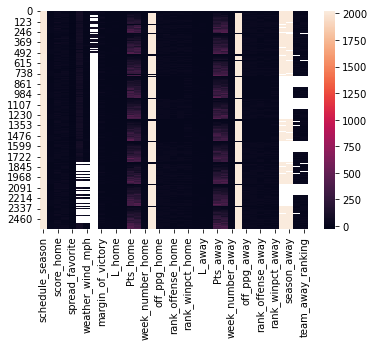

In [32]:
# Exploratory Analysis

scores_and_rankings_all[['W_home', 'off_ppg_away']] = scores_and_rankings_all[['W_home', 'off_ppg_away']].fillna(0)
numeric_data = scores_and_rankings_all.select_dtypes(include=[np.number])
sns.heatmap(numeric_data)

In [1]:
# Trying unsupervised methods to group games and look at mix of blowouts/non-blowouts

from sklearn.cluster import KMeans

my_kmeans = KMeans()



In [ ]:
# TODO
# How to determine if offense/defense is good on early weeks? Need preseason offense/defense ratings, 
### cannot use preseason
# Add player data
# Consider the threshold games...difference between 14 and 15 is win/loss
# Raiders, Rams, Chargers all need translations to new team (for standings and predictive scores)...get name mapping from year-to-year
# Check the prior year logic after the above bullet is completed
# Finish doing the offense and defense ranking adjustments once prior year data is in place (similar blend to the overall ranking)

In [ ]:
# Old code
# Is the team bad? Preseason ranking used before week 8, otherwise, use the win percentage rank

#scores_and_rankings_all['team_home_ranking_old'] = scores_and_rankings_all['Predictive_home'].where(
#    scores_and_rankings_all['schedule_week'] <= 7, scores_and_rankings_all['rank_winpct_home']
#)

#scores_and_rankings_all['team_away_ranking'] = scores_and_rankings_all['Predictive_away'].where(
#    scores_and_rankings_all['schedule_week'] <= 7, scores_and_rankings_all['rank_winpct_away']
#)